In [3]:
import copy
import logging
import argparse
import sys, os
import numpy as np
from math import pi
import matplotlib.pyplot as plt
from os.path import dirname, abspath, join
sys.path.append("../")

import matplotlib

%matplotlib inline

import matplotlib as mpl
mpl.use('Qt5Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure

from Grids import createGrid
from ValueFuncs import *
from Visualization import *
from DynamicalSystems import *
from InitialConditions import shapeCylinder
from Utilities import *
from ExplicitIntegration import *
from SpatialDerivative import *
from Visualization.value_viz import ValueVisualizer

In [4]:
obj = Bundle({})

# define the target set
def get_target(g):
	cylinder = shapeCylinder(g.grid, g.axis_align, g.center, g.radius);
	return cylinder

def get_hamiltonian_func(t, data, deriv, finite_diff_data):
	global obj
	ham_value = deriv[0] * obj.p1_term + \
				deriv[1] * obj.p2_term - \
				obj.omega_e_bound*np.abs(deriv[0]*obj.grid.xs[1] - \
				deriv[1] * obj.grid.xs[0] - deriv[2])  + \
				obj.omega_p_bound * np.abs(deriv[2])

	return ham_value, finite_diff_data

def get_partial_func(t, data, derivMin, derivMax, \
			  schemeData, dim):
	"""
		Calculate the extrema of the absolute value of the partials of the
		analytic Hamiltonian with respect to the costate (gradient).
	"""
	global obj

	# print('dim: ', dim)
	assert dim>=0 and dim <3, "grid dimension has to be between 0 and 2 inclusive."

	return obj.alpha[dim]

In [5]:
## Grid
grid_min = expand(np.array((-.75, -1.25, -pi)), ax = 1) # Lower corner of computation domain
grid_max = expand(np.array((3.25, 1.25, pi)), ax = 1)   # Upper corner of computation domain
pdDims = 2                      # 3rd dimension is periodic
resolution = 100
N = np.array(([[
                resolution,
                np.ceil(resolution*(grid_max[1, 0] - grid_min[1, 0])/ \
                            (grid_max[0, 0] - grid_min[0, 0])),
                resolution-1
                ]])).T.astype(int)
grid_max[2, 0]*= (1-2/N[2])

# global obj
# print(obj.__dict__)

obj.grid = createGrid(grid_min, grid_max, N, pdDims)

# global params
obj.axis_align, obj.center, obj.radius = 2, np.zeros((3, 1)), 0.5
data0 = get_target(obj)

data = copy.copy(data0)

obj.v_e			  = +1
obj.v_p			  = +1

obj.omega_e_bound = +1
obj.omega_p_bound = +1

t_range = [0, 2.5]

obj.p1_term = obj.v_e - obj.v_p * np.cos(obj.grid.xs[2])
obj.p2_term = -obj.v_p * np.sin(obj.grid.xs[2])
obj.alpha = [ np.abs(obj.p1_term) + np.abs(obj.omega_e_bound * obj.grid.xs[1]), \
                np.abs(obj.p2_term) + np.abs(obj.omega_e_bound * obj.grid.xs[0]), \
                obj.omega_e_bound + obj.omega_p_bound ]

small = 100*eps
level = 0

finite_diff_data = Bundle({'grid': obj.grid, 'hamFunc': get_hamiltonian_func,
                            'partialFunc': get_partial_func,
                            'dissFunc': artificialDissipationGLF,
                            'derivFunc': upwindFirstENO2,
                            })

options = Bundle(dict(factorCFL=0.95, stats='on', singleStep='off'))
integratorOptions = odeCFLset(options)

"""
---------------------------------------------------------------------------
 Restrict the Hamiltonian so that reachable set only grows.
   The Lax-Friedrichs approximation scheme MUST already be completely set up.
"""
innerData = copy.copy(finite_diff_data)
del finite_diff_data

# Wrap the true Hamiltonian inside the term approximation restriction routine.
schemeFunc = termRestrictUpdate
finite_diff_data = Bundle(dict(innerFunc = termLaxFriedrichs,
                               innerData = innerData,
                               positive = 0
                            ))

# Period at which intermediate plots should be produced.
plot_steps = 11
t_plot = (t_range[1] - t_range[0]) / (plot_steps - 1)
# Loop through t_range (subject to a little roundoff).
t_now = t_range[0]
start_time = cputime()

# plt.close('all')
# Visualization paramters
spacing = tuple(obj.grid.dx.flatten().tolist())
init_mesh = implicit_mesh(data, level=0, spacing=spacing,  edge_color='orange',
                         face_color='orange')
params = Bundle(
        {"grid": obj.grid,
         'disp': True,
         'labelsize': 16,
         'labels': "Initial 0-LevelSet",
         'linewidth': 2,
         'data': data,
         'mesh': init_mesh,
         'init_conditions': False,
         'pause_time': args.pause_time,
         'level': 0, # which level set to visualize
         'winsize': (12,7),
         'fontdict': Bundle({'fontsize':12, 'fontweight':'bold'}),
         "savedict": Bundle({"save": False,
                        "savename": "rcbrt",
                        "savepath": "../jpeg_dumps/rcbrt"})
         })

rcbrt_viz = RCBRTVisualizer(params=params)
delete_last_plot = False

while(t_range[1] - t_now > small * t_range[1]):

    time_step = f"{t_now}/{t_range[-1]}"
    if(strcmp(options.stats, 'on')):
        info(f"Iteration: {time_step}")

    # Reshape data array into column vector for ode solver call.
    y0 = data.flatten()

    # How far to step?
    t_span = np.hstack([ t_now, min(t_range[1], t_now + t_plot) ])

    # Take a timestep.
    t, y, _ = odeCFL2(termRestrictUpdate, t_span, y0, integratorOptions, finite_diff_data)
    t_now = t

    # Get back the correctly shaped data array
    data = np.reshape(y, obj.grid.shape)

    # TODO: Why doesn't mesh have zero values?
    # mesh=implicit_mesh(data, level=None, spacing=spacing,  edge_color='red',
    #                      face_color='red')
    verts, faces, normals, values = measure.marching_cubes(data, level=None, spacing=spacing, gradient_direction='descent')
    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces])
    mesh.set_edgecolor('magenta')
    mesh.set_facecolor('magenta')

    rcbrt_viz.update_tube(data, mesh, time_step, delete_last_plot)

    delete_last_plot = True

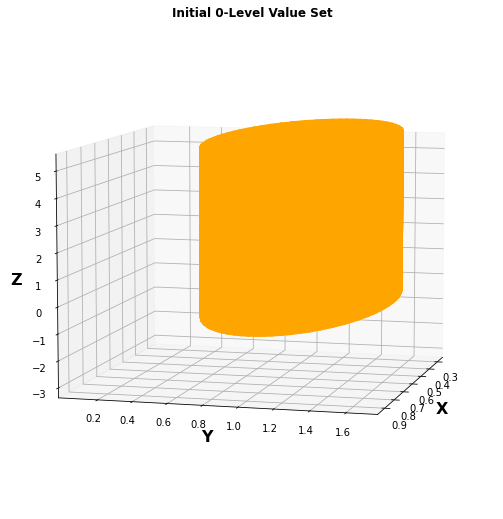

In [38]:
fig = plt.figure(figsize=(16,9))
# gs = gridspec.Gridspec(1,1, fig)
ax_idx = fig.add_subplot(111, projection='3d')

spacing = tuple(obj.grid.dx.flatten().tolist())
mesh = implicit_mesh(data, level=params.level, spacing=spacing,  edge_color='orange', 
                         face_color='orange')
# ax_idx = plt.subplot(111, projection='3d')
ax_idx.add_collection3d(mesh)
ax_idx.view_init(elev=8., azim=15.)

xlim = (min(data[0].ravel()), max(data[0].ravel()))
ylim = (min(data[1].ravel())-.2, max(data[1].ravel())+.8)
zlim = (min(data[2].ravel()), max(data[2].ravel()))

ax_idx.set_xlim(*xlim)
ax_idx.set_ylim(*ylim)
ax_idx.set_zlim(-np.pi-.05, np.pi+2.3)

ax_idx.set_xlabel("X", fontdict = params.fontdict.__dict__)
ax_idx.set_ylabel("Y", fontdict = params.fontdict.__dict__)
ax_idx.set_zlabel("Z", fontdict = params.fontdict.__dict__)
ax_idx.set_title(f'Initial {params.level}-Level Value Set', fontweight=params.fontdict.fontweight)
plt.show()

In [33]:
np.amin(faces, axis=0)

array([0, 1, 0])

In [7]:
data.shape, tuple(obj.grid.dx.flatten().tolist())

((100, 63, 99), (0.04, 0.03968253968253968, 0.0621908418849785))

In [15]:
max(data.flatten())

-0.9758325004892114

In [13]:


verts, faces, normals, values = measure.marching_cubes(data, level=None, spacing=spacing, gradient_direction='descent')
# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
mesh.set_edgecolor('r')

RuntimeError: Can not put single artist in more than one figure

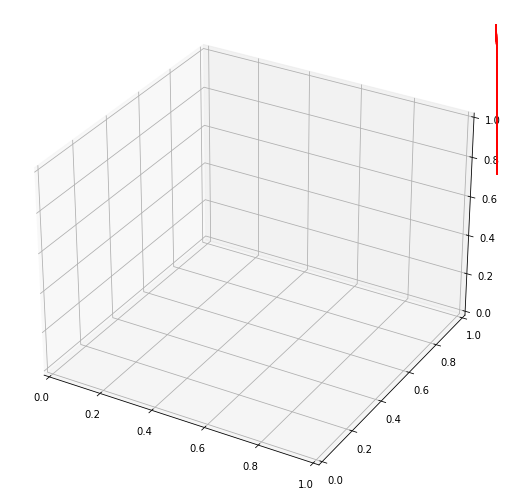

In [25]:
fig = plt.figure(figsize=(16,9))
# gs = gridspec.Gridspec(1,1, fig)
ax_idx = fig.add_subplot(111, projection='3d')
ax_idx.add_collection3d(mesh)
ax_idx.view_init(elev=8., azim=15.)
buffer_factor=1.05
xlim = (min(faces[:,0].ravel()), max(faces[:,0].ravel()))
ylim = (min(faces[:,1].ravel())-.2, max(faces[:,1].ravel())+.8)
zlim = (min(faces[:,2].ravel()), max(faces[:,2].ravel()))

ax_idx.set_xlim(*xlim)
ax_idx.set_ylim(*ylim)
ax_idx.set_zlim(*zlim)

In [23]:
# val_dat = values.reshape(data.shape)
100*63*99, faces.shape, np.prod([17248, 3])

(623700, (17248, 3), 51744)

In [22]:
help(measure.marching_cubes)

Help on function marching_cubes in module skimage.measure._marching_cubes_lewiner:

marching_cubes(volume, level=None, *, spacing=(1.0, 1.0, 1.0), gradient_direction='descent', step_size=1, allow_degenerate=True, method='lewiner', mask=None)
    Marching cubes algorithm to find surfaces in 3d volumetric data.
    
    In contrast with Lorensen et al. approach [2]_, Lewiner et
    al. algorithm is faster, resolves ambiguities, and guarantees
    topologically correct results. Therefore, this algorithm generally
    a better choice.
    
    Parameters
    ----------
    volume : (M, N, P) array
        Input data volume to find isosurfaces. Will internally be
        converted to float32 if necessary.
    level : float, optional
        Contour value to search for isosurfaces in `volume`. If not
        given or None, the average of the min and max of vol is used.
    spacing : length-3 tuple of floats, optional
        Voxel spacing in spatial dimensions corresponding to numpy array
  